<h1 align="center" style="margin: 0; font-size: 36px;">Neural and Evolutionary Learning</h1>
<br>
<h1 align="center" style="margin: 0; font-size: 30px;">Project partial deliverable 5 (NEAT)</h1>

<br>

**Group members:**<br>
Bárbara Capitão - 20211532@novaims.unl.pt <br>
Carolina Silvestre - 20211512@novaims.unl.pt <br>
Lara Leandro - 20211632@novaims.unl.pt <br>


### Requirements
-  Fit a NEAT to the project dataset, including the hyperparameter tuning phase.
- Discuss th, overfitting, and premature convergence on the algorithm.
- Include your own insights and summary conclusionr>

### Table of Contents
[Imports](#chapter_1) <br>
[Settings](#chapter_2) <br>
[Load Data](#chapter_3) <br>
[Data Understanding](#chapter_4) <br>
[Data Preprocessing](#chapter_5) <br>
[Cross-Validation](#chapter_6) <br>
[NeuroEvolution of Augmenting Topologies (NEAT)](#chapter_7) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[Configuration](#subchapter_7_1) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[Functions](#subchapter_7_2) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[Problem Instance Definitio](#subchapter_7_4) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[Evolution Graphs](#subchapter_7_3) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Variation of RMSE across Models](#subchapter_7_3_1) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Train vs Test Fitness ](#subchapter_7_3_2) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Fitness Diversity](#s4bchapter_7_3_5) <br>
[Final Evaluation](#chapter_8) <br>


<a id="chapter_1"></a>
## Imports


In [1]:
import sys
#!{sys.executable} -m pip install neat-python
#!pip install graphviz


In [2]:
# Standard Library
import os
import re
import random
import copy
import pickle
import datetime
from itertools import product
from collections import defaultdict

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Data Handling
import numpy as np
import pandas as pd

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Scikit-learn
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Statistical tests
from scipy.stats import spearmanr, shapiro

# Other Libraries
import joblib
import neat
import visualize


<a id="chapter_2"></a>
## Settings

In [3]:
device = 'cpu'
seed = 43
np.random.seed(seed)
random.seed(seed)

In [4]:
train_color = 'blue'
test_color = 'orange'
size_color = 'green'

<a id="chapter_3"></a>
## Load Data

In [5]:
# Load Excel file
df = pd.read_excel("sustavianfeed.xlsx")

In [6]:
df

WING TAG  WEIGHT  HOT CARCASS WEIGHT  CARCASS WEIGHT WITH HEAD AND LEGS  \
0      G403  2223.3              1429.6                             1725.6   
1      G439  2201.9              1450.2                             1769.8   
2      G454  2159.9              1398.4                             1724.9   
3      G465  2198.7              1473.9                             1800.4   
4      G428  2003.2              1291.2                             1581.6   
..      ...     ...                 ...                                ...   
91     V476  2633.1              1683.2                             2034.1   
92     V454  2346.2              1547.8                             1819.5   
93     V425  2648.2              1722.9                             2050.0   
94     V490  2262.6              1498.5                             1813.9   
95     V428  2704.3              1698.8                             2038.8   

    COLD CARCASS WEIGHT  BREAST WEIGHT (2)  THIGH WEIGHT (2)  SPLEEN   LIVER  \
0                1394.0              214.0             489.4   3.716  38.636   
1                1405.4              236.0             538.7   3.494  34.725   
2                1461.7              241.8             512.1   4.023  31.932   
3                1425.1              227.7             549.9   3.087  32.326   
4                1260.1              224.7             473.2   3.723  30.105   
..                  ...                ...               ...     ...     ...   
91               1637.2              213.8             610.9   4.777  45.992   
92               1511.2              228.0             528.2   3.673  35.090   
93               1669.8              253.1             610.0   5.176  50.505   
94               1468.0              212.1             548.4   2.829  30.266   
95               1655.6              245.7             606.9   5.960  40.922   

     HEART  INTESTINE EMPTY MUSCULAR STOMACH  GLANDULAR STOMACH  \
0    9.305    123.171                      /             13.170   
1   10.084     71.800                 45.273              9.781   
2   10.635     61.380                      /              6.217   
3   11.927     64.879                 35.861              8.358   
4    9.855     68.562                 36.526              7.572   
..     ...        ...                    ...                ...   
91  12.796     74.888                 54.021              7.857   
92  11.504     68.455                 42.173              7.837   
93  17.194     81.502                   49.7              7.332   
94  11.129     53.011                 46.816              5.425   
95  16.190     72.783                 75.767              7.420   

    CRUDE PROTEIN  ETHER EXTRACT  
0       86.105469           0.38  
1       86.143472           1.66  
2       86.416898           0.98  
3       85.959935           1.10  
4       81.693637           6.34  
..            ...            ...  
91      88.999126           1.07  
92      88.507288           1.13  
93      90.375587           1.91  
94      91.211353           2.21  
95      88.825045           1.51  

[96 rows x 15 columns]

In [7]:
# Droping ID column
df.drop(columns=['WING TAG'], inplace=True)

<a id="chapter_4"></a>
## Data Understanding

In [8]:
df.describe()

WEIGHT  HOT CARCASS WEIGHT  CARCASS WEIGHT WITH HEAD AND LEGS  \
count    96.000000           96.000000                          96.000000   
mean   2339.682292         1521.955208                        1833.378125   
std     200.943424          144.126939                         154.000550   
min    1968.400000         1284.900000                        1554.400000   
25%    2201.775000         1425.775000                        1723.800000   
50%    2299.500000         1493.050000                        1809.400000   
75%    2473.800000         1608.400000                        1922.725000   
max    2890.500000         1929.400000                        2262.800000   

       COLD CARCASS WEIGHT  BREAST WEIGHT (2)  THIGH WEIGHT (2)     SPLEEN  \
count            96.000000          96.000000         96.000000  96.000000   
mean           1481.479167         234.116667        542.205208   4.219917   
std             142.830115          37.818405         60.994468   0.998836   
min            1252.600000         177.100000        177.800000   2.464000   
25%            1380.825000         218.775000        508.225000   3.534250   
50%            1452.800000         231.550000        538.100000   4.048000   
75%            1573.700000         243.275000        573.850000   4.817000   
max            1891.700000         533.200000        690.600000   7.758000   

           LIVER      HEART   INTESTINE  GLANDULAR STOMACH  CRUDE PROTEIN  \
count  96.000000  96.000000   96.000000          96.000000      96.000000   
mean   36.781427  12.059240   69.149156           8.184677      87.313708   
std     5.438894   1.932239   11.727467           1.697425       2.043895   
min    25.916000   8.561000   44.133000           5.425000      73.837184   
25%    33.053000  10.584250   62.274250           7.012750      86.544416   
50%    35.936000  11.679000   68.019500           7.809500      87.574947   
75%    40.485000  13.449750   75.103000           9.016750      88.508026   
max    53.133000  17.194000  123.171000          13.170000      91.211353   

       ETHER EXTRACT  
count      96.000000  
mean        2.090417  
std         1.351645  
min         0.320000  
25%         1.130000  
50%         1.710000  
75%         2.527500  
max         6.680000

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   WEIGHT                             96 non-null     float64
 1   HOT CARCASS WEIGHT                 96 non-null     float64
 2   CARCASS WEIGHT WITH HEAD AND LEGS  96 non-null     float64
 3   COLD CARCASS WEIGHT                96 non-null     float64
 4   BREAST WEIGHT (2)                  96 non-null     float64
 5   THIGH WEIGHT (2)                   96 non-null     float64
 6   SPLEEN                             96 non-null     float64
 7   LIVER                              96 non-null     float64
 8   HEART                              96 non-null     float64
 9   INTESTINE                          96 non-null     float64
 10  EMPTY MUSCULAR STOMACH             96 non-null     object 
 11  GLANDULAR STOMACH                  96 non-null     float64
 

> The column 'EMPTY MUSCULAR STOMACH' has been read as type object, possibly because some entries contain non-numeric or unexpected values, preventing it from being interpreted as float

In [10]:
df['EMPTY MUSCULAR STOMACH'].value_counts()

EMPTY MUSCULAR STOMACH
/         5
75.767    2
47.964    1
51.322    1
59.583    1
         ..
63.571    1
49.648    1
43.586    1
53.456    1
46.816    1
Name: count, Length: 91, dtype: int64

> The 'EMPTY MUSCULAR STOMACH' as 5 values '/'

In [11]:
# Coverting the column to numeric, forcing '/' to became Nan
df['EMPTY MUSCULAR STOMACH'] = pd.to_numeric(df['EMPTY MUSCULAR STOMACH'], errors='coerce')

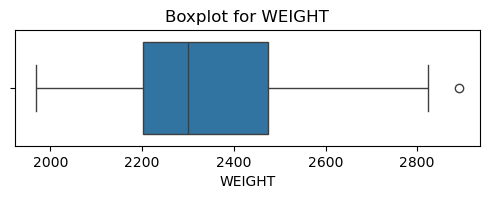

WEIGHT — Outliers detected: 1


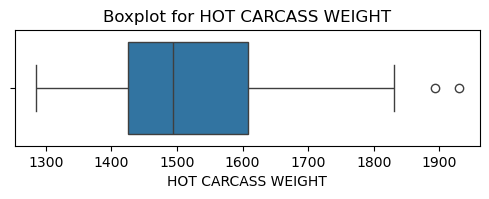

HOT CARCASS WEIGHT — Outliers detected: 2


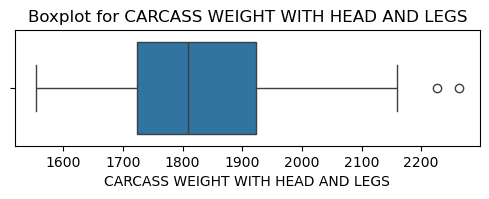

CARCASS WEIGHT WITH HEAD AND LEGS — Outliers detected: 2


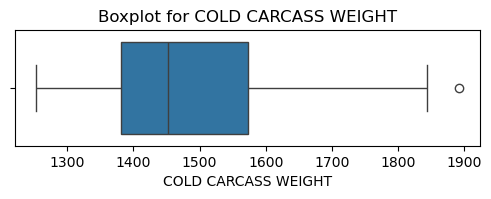

COLD CARCASS WEIGHT — Outliers detected: 1


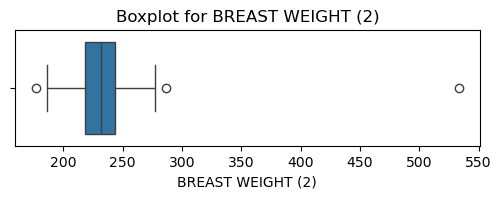

BREAST WEIGHT (2) — Outliers detected: 3


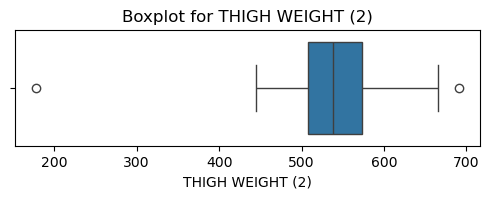

THIGH WEIGHT (2) — Outliers detected: 2


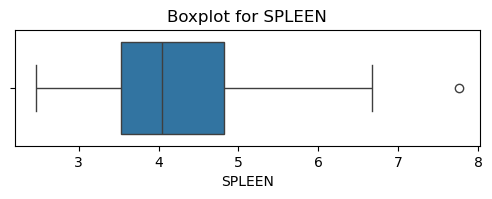

SPLEEN — Outliers detected: 1


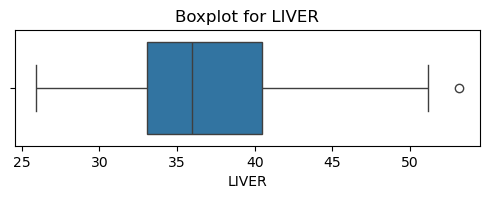

LIVER — Outliers detected: 1


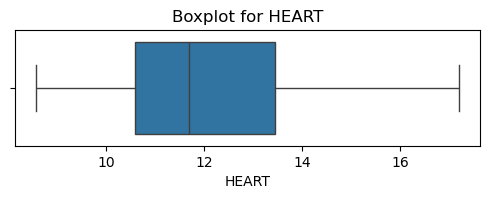

HEART — Outliers detected: 0


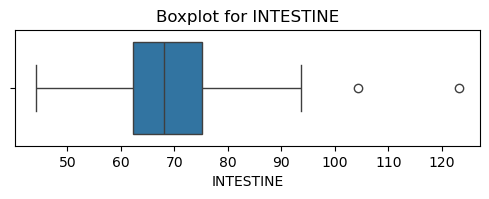

INTESTINE — Outliers detected: 2


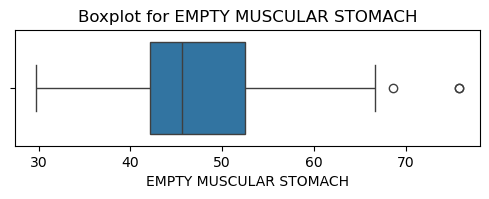

EMPTY MUSCULAR STOMACH — Outliers detected: 3


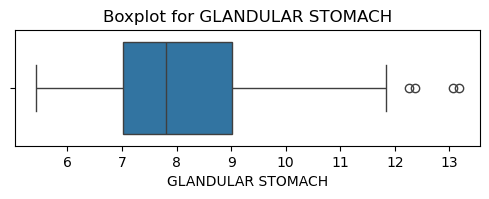

GLANDULAR STOMACH — Outliers detected: 4


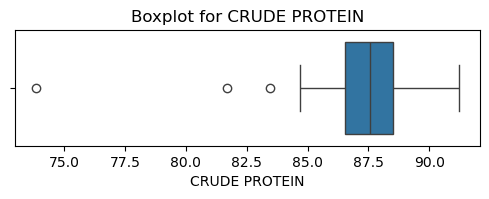

CRUDE PROTEIN — Outliers detected: 3


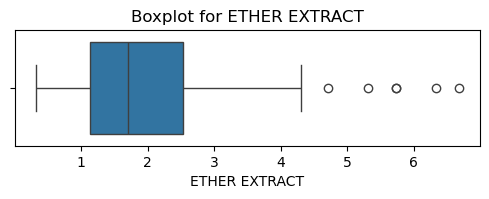

ETHER EXTRACT — Outliers detected: 6


In [12]:
def detect_outliers_iqr(df):
    outlier_info = {}

    for col in df.select_dtypes(include = [np.number] ).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Geting the outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        outlier_info[col] = {
            'count': outliers.count(),
            'outliers': outliers.values
        }

        # Ploting the boxplots
        plt.figure(figsize=(6, 1.5))
        sns.boxplot(x=df[col], orient='h' )
        plt.title(f"Boxplot for {col}")
        plt.show()

        print(f"{col} — Outliers detected: {outliers.count()}")
    
    return outlier_info

outlier_summary = detect_outliers_iqr(df)

Most columns contain some outliers, but they are few in number and not particularly extreme, so we’ve decided to keep them.
The most notable outliers appear in:

- Breast weight: typically ranges from 200–250, but one value is around 550.

- Thigh weight: usually between 450–650, but there's one outlier close to 200.

- Crude protein: generally falls between 85–95, but there's a value near 72.5.


 Analyzing column: WEIGHT


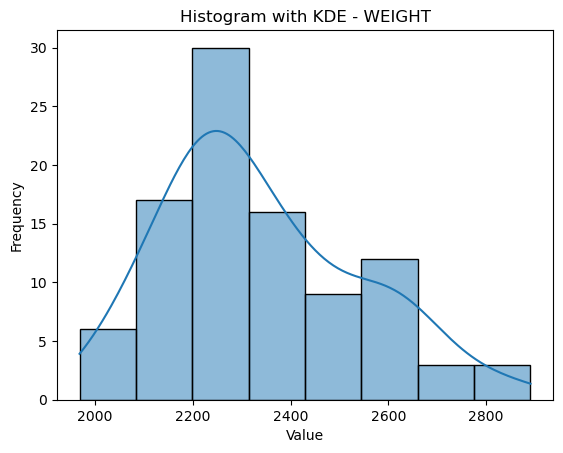

Shapiro-Wilk Test statistic = 0.9641, p-value = 0.0100
 Not normally distributed (reject H0)

 Analyzing column: HOT CARCASS WEIGHT


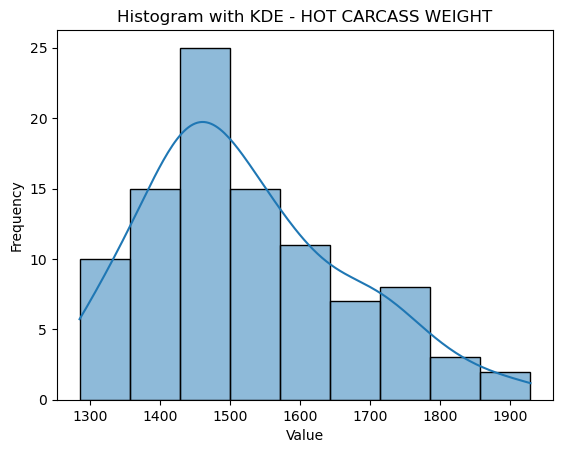

Shapiro-Wilk Test statistic = 0.9611, p-value = 0.0061
 Not normally distributed (reject H0)

 Analyzing column: CARCASS WEIGHT WITH HEAD AND LEGS


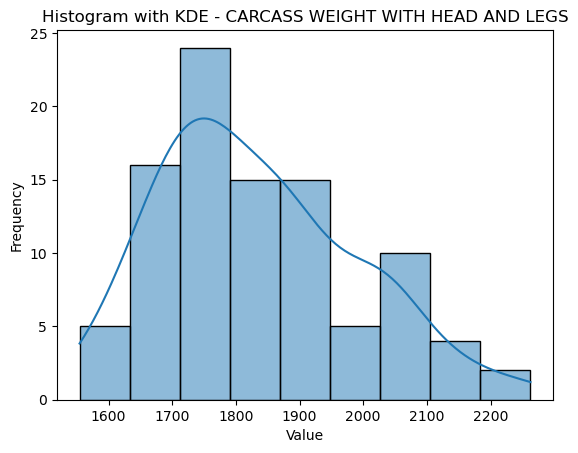

Shapiro-Wilk Test statistic = 0.9641, p-value = 0.0099
 Not normally distributed (reject H0)

 Analyzing column: COLD CARCASS WEIGHT


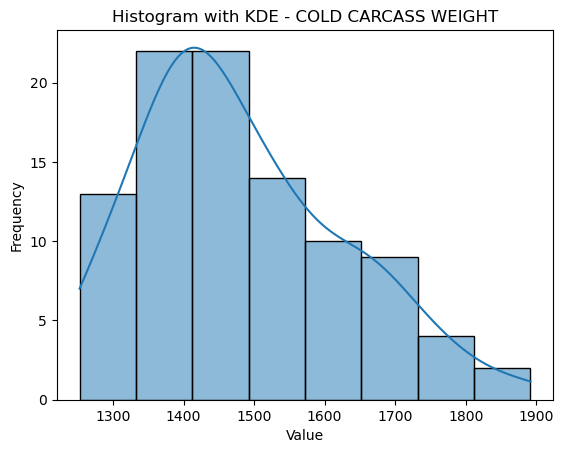

Shapiro-Wilk Test statistic = 0.9577, p-value = 0.0036
 Not normally distributed (reject H0)

 Analyzing column: BREAST WEIGHT (2)


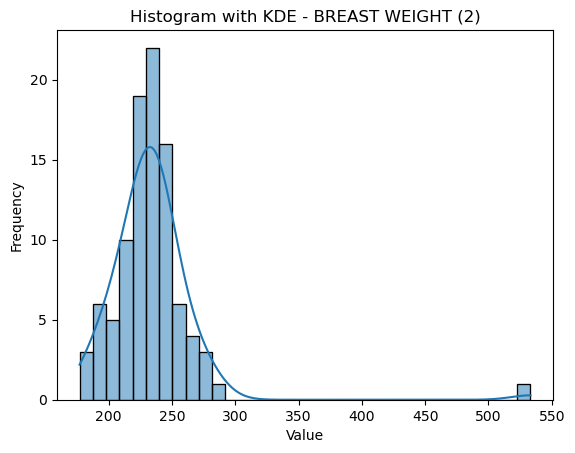

Shapiro-Wilk Test statistic = 0.6057, p-value = 0.0000
 Not normally distributed (reject H0)

 Analyzing column: THIGH WEIGHT (2)


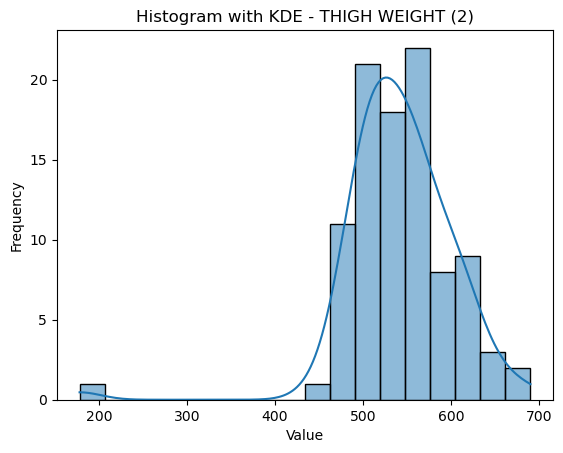

Shapiro-Wilk Test statistic = 0.8492, p-value = 0.0000
 Not normally distributed (reject H0)

 Analyzing column: SPLEEN


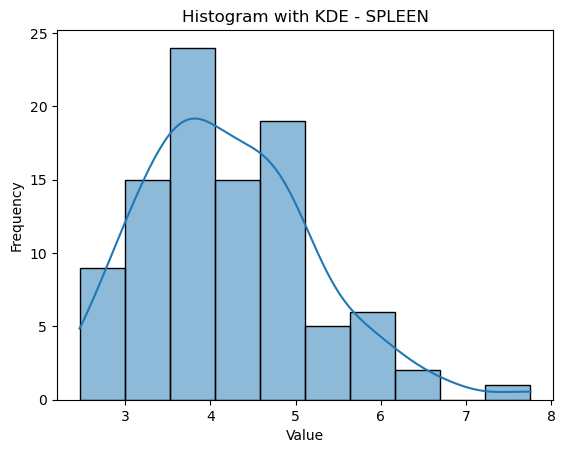

Shapiro-Wilk Test statistic = 0.9657, p-value = 0.0129
 Not normally distributed (reject H0)

 Analyzing column: LIVER


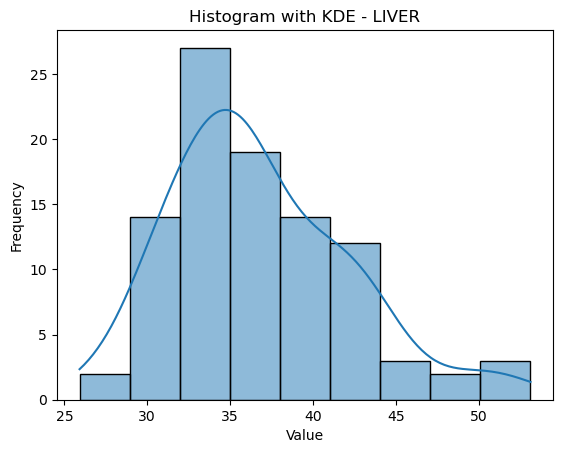

Shapiro-Wilk Test statistic = 0.9633, p-value = 0.0086
 Not normally distributed (reject H0)

 Analyzing column: HEART


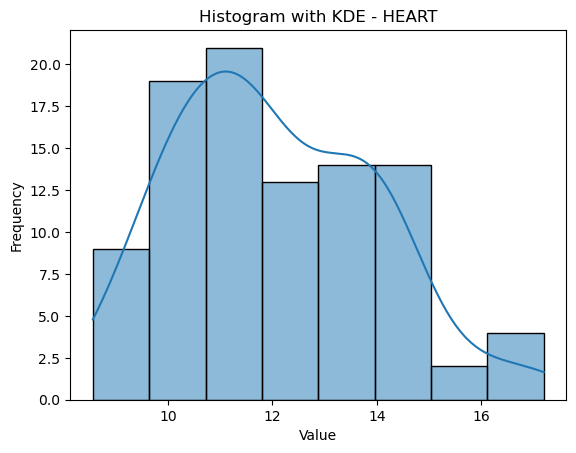

Shapiro-Wilk Test statistic = 0.9730, p-value = 0.0443
 Not normally distributed (reject H0)

 Analyzing column: INTESTINE


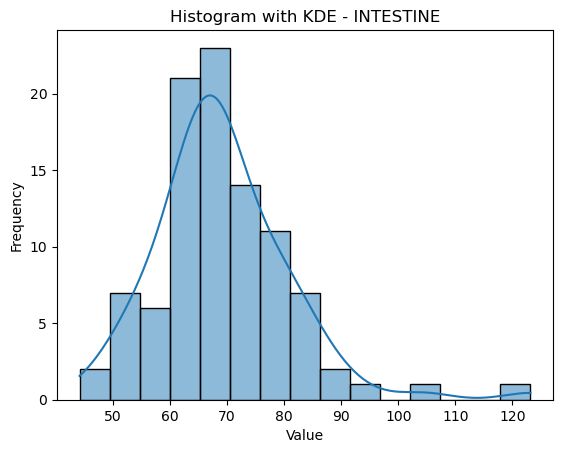

Shapiro-Wilk Test statistic = 0.9302, p-value = 0.0001
 Not normally distributed (reject H0)

 Analyzing column: EMPTY MUSCULAR STOMACH


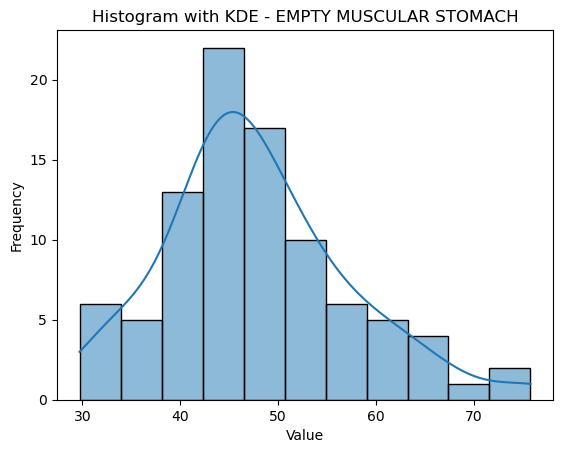

Shapiro-Wilk Test statistic = 0.9656, p-value = 0.0167
 Not normally distributed (reject H0)

 Analyzing column: GLANDULAR STOMACH


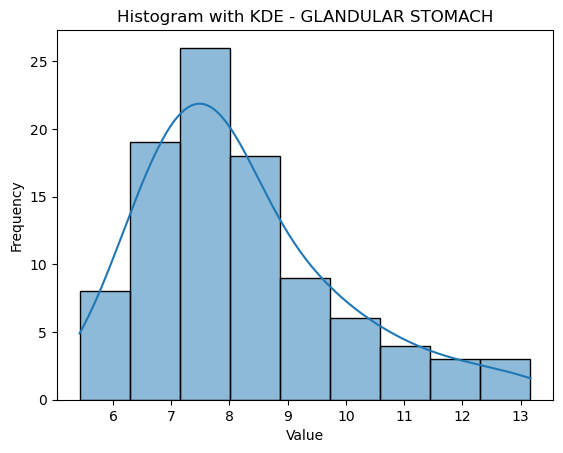

Shapiro-Wilk Test statistic = 0.9303, p-value = 0.0001
 Not normally distributed (reject H0)

 Analyzing column: CRUDE PROTEIN


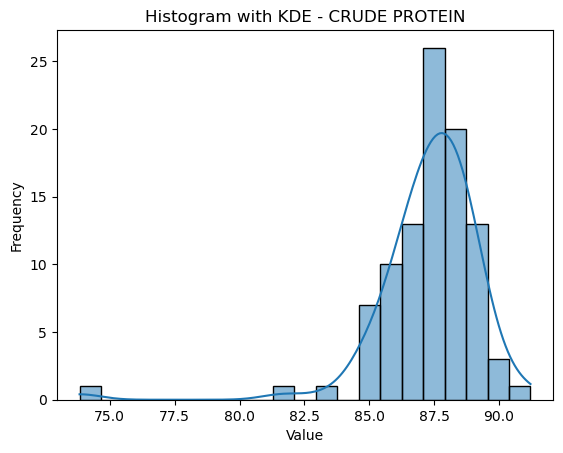

Shapiro-Wilk Test statistic = 0.7674, p-value = 0.0000
 Not normally distributed (reject H0)

 Analyzing column: ETHER EXTRACT


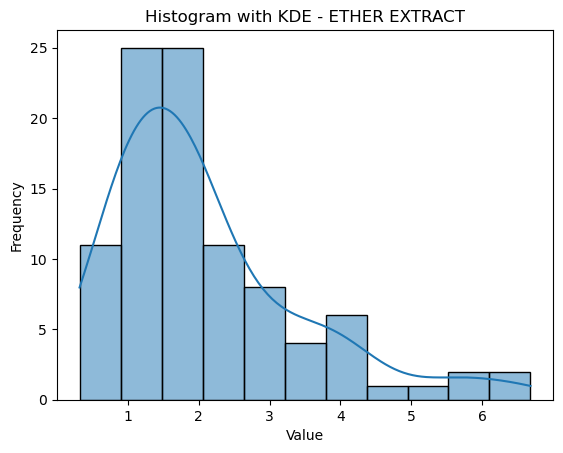

Shapiro-Wilk Test statistic = 0.8674, p-value = 0.0000
 Not normally distributed (reject H0)


In [13]:
# Checking if the data is normally distributed

for column in df.select_dtypes(include=[np.number]).columns:
    print(f"\n Analyzing column: {column}")
    data = df[column].dropna()  

    # Histogram + KDE
    sns.histplot(data, kde=True)
    plt.title(f"Histogram with KDE - {column}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()


    # Shapiro-Wilk Test
    stat, p = shapiro(data)
    print(f"Shapiro-Wilk Test statistic = {stat:.4f}, p-value = {p:.4f}")
    if p > 0.05:
        print(" Likely normal (fail to reject H0)")
    else:
        print(" Not normally distributed (reject H0)")


> All columns in the dataset exhibit non-normal distributions, as confirmed by visual inspection and statistical tests 

<a id="chapter_5"></a>
## Data Preprocessing

In [14]:
# Missing Values
# Calculating the mean
mean_value = df['EMPTY MUSCULAR STOMACH'].mean()

# Replacing the NaNs with the mean
df['EMPTY MUSCULAR STOMACH'] = df['EMPTY MUSCULAR STOMACH'].fillna(mean_value)


In [15]:
# Separating the features from the target
features = df.drop(columns=['CRUDE PROTEIN'])
target = df['CRUDE PROTEIN']

# Scaling the features
#scaler = RobustScaler() # since the data is not normally distributed and contains outliers, we opted to use the RobustScaler
#X_scaled = scaler.fit_transform(features)


X = torch.tensor(features.values, dtype=torch.float32)
y = torch.tensor(target.values, dtype=torch.float32)

<a id="chapter_6"></a>
## Cross-Validation

In [16]:
# Nested Cross Validation
k_outer = 5
k_inner = 3
cv_outer = KFold(n_splits=k_outer, random_state=seed, shuffle=True)
cv_inner = KFold(n_splits=k_inner, random_state=seed, shuffle=True)

We opted to use **nested cross-validation** instead of Monte Carlo because it gives a more confident and reliable estimate of how well the model will perform on new data. The **outer loop** is used to test the model, while the **inner loop** is used for hyperparameter tuning. This setup helps avoid overfitting during tuning and gives a more honest evaluation of the model’s generalization performance.

We chose **5 outer folds** because it gives a good balance between reliable performance estimates and computation time. For the **inner loop**, we used **3 folds** to keep hyperparameter tuning efficient without sacrificing too much accuracy..


<a id="chapter_7"></a>
## NeuroEvolution of Augmenting Topologies (NEAT)

<a id="subchapter_7_1"></a>
### Configuration

In [17]:
config_text = """
[NEAT]
fitness_criterion     = max
fitness_threshold     = 100.0
pop_size              = 100
reset_on_extinction   = False

[DefaultGenome]
# Network structure
num_inputs            = 13
num_outputs           = 1
num_hidden            = 0
feed_forward          = True
initial_connection    = full_direct

# Activation functions
activation_default      = sigmoid
activation_mutate_rate  = 0.2
activation_options      = sigmoid relu tanh

# Aggregation functions
aggregation_default     = sum
aggregation_mutate_rate = 0.0
aggregation_options     = sum

# Bias
bias_init_mean          = 0.0
bias_init_stdev         = 1.0
bias_max_value          = 30.0
bias_min_value          = -30.0
bias_mutate_power       = 0.5
bias_mutate_rate        = 0.7
bias_replace_rate       = 0.1

# Compatibility
compatibility_disjoint_coefficient = 1.0
compatibility_weight_coefficient   = 0.5

# Connection
conn_add_prob           = 0.8
conn_delete_prob        = 0.2
enabled_default         = True
enabled_mutate_rate     = 0.01

# Node
node_add_prob           = 0.2
node_delete_prob        = 0.2

# Response
response_init_mean      = 1.0
response_init_stdev     = 0.0
response_max_value      = 30.0
response_min_value      = -30.0
response_mutate_power   = 0.0
response_mutate_rate    = 0.0
response_replace_rate   = 0.0

# Weight
weight_init_mean        = 0.0
weight_init_stdev       = 1.0
weight_max_value        = 30
weight_min_value        = -30
weight_mutate_power     = 0.5
weight_mutate_rate      = 0.8
weight_replace_rate     = 0.1

[DefaultSpeciesSet]
compatibility_threshold = 3.0

[DefaultStagnation]
species_fitness_func = max
max_stagnation       = 20
species_elitism      = 2

[DefaultReproduction]
elitism            = 2
survival_threshold = 0.2
"""

# Save to temporary config file
with open("temp_neat_config.cfg", "w") as f:
    f.write(config_text)



In [18]:
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     "temp_neat_config.cfg")
print(config.genome_config)

<a id="subchapter_7_2"></a>
### Functions

In [19]:
def eval_rmse(net, X, y):
    '''
    Auxiliary funciton to evaluate the RMSE.
    '''
    fit = 0.
    for xi, xo in zip(X, y):
        output = net.activate(xi)
        fit += (output[0] - xo.item())**2
    # RMSE
    return (fit/len(y))**.5


fitness_std_history = []

def eval_genomes(genomes, config):
    '''
    The function used by NEAT-Python to evaluate the fitness of the genomes.
    -> It has to have the two first arguments genomes and config.
    -> It has to update the `fitness` attribute of the genome.
    '''
    global X_train, y_train, X_val, y_val  
    
    fits = []

    for genome_id, genome in genomes:
        # Define the network
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        # Train fitness
        genome.fitness = -eval_rmse(net, X_train, y_train)
        # Validation fitness
        genome.fitness_val = -eval_rmse(net, X_val, y_val) 
        fits.append(genome.fitness)

    fitness_std_history.append(np.std(fits))     

<a id="subchapter_7_4"></a>
### Problem Instance Definition 

In [20]:
DATASET_NAME = 'Sustavian'

total_instances = X.shape[0]
outer_test_size = total_instances // k_outer
outer_train_size = total_instances - outer_test_size
inner_val_size = outer_train_size // k_inner
inner_train_size = outer_train_size - inner_val_size

print(f'Total Instances:\t{total_instances}\n--')
print(f'Outer Train set:\t{outer_train_size}')
print(f'Test set:\t\t{outer_test_size}\n--')
print(f'Inner Train set:\t{inner_train_size}')
print(f'Validation set:\t\t{inner_val_size}\n')

Total Instances:	96
--
Outer Train set:	77
Test set:		19
--
Inner Train set:	52
Validation set:		25



In [21]:
# Create the population, which is the top-level object for a NEAT run
p = neat.Population(config)

In [22]:
# Add a stdout reporter to show progress in the terminal
GENERATIONS = 80

p.add_reporter(neat.StdOutReporter(False))
stats = neat.StatisticsReporter()
p.add_reporter(stats)
p.add_reporter(neat.Checkpointer(int(GENERATIONS/3)))


In [23]:
def modify_config_template(base_config_path, output_config_path, param_values):
    """
    Copies base_config.cfg and modifies lines that match the keys in param_values
    """
    with open(base_config_path, 'r') as f:
        lines = f.readlines()

    new_lines = []
    for line in lines:
        modified = False
        for param, val in param_values.items():
            if re.match(fr"^\s*{param}\s*=", line):
                new_lines.append(f"{param} = {val}\n")
                modified = True
                break
        if not modified:
            new_lines.append(line)

    with open(output_config_path, 'w') as f:
        f.writelines(new_lines)


In [24]:
#### Fixed NEAT parameters ####
fixed_params = {
    "n_generations": GENERATIONS,
    "eval_function": eval_genomes,
    "config_template": "temp_neat_config.cfg",
    "verbose": True
}

#### Parameter grid to search ####
param_grid = {
 #  'pop_size': [50, 100, 200],
    'weight_mutate_rate': [0.5, 0.8],
#    'node_add_prob': [0.05, 0.1],
    'conn_add_prob': [0.1, 0.3],
 #   'elitism': [1, 2],
    'survival_threshold': [0.2, 0.4],
 #   'max_stagnation': [20, 30],
 #   'compatibility_threshold': [2.0, 3.0]
}


def call_neat(fixed_params, param_grid, seed):
    results = []
    keys, values = zip(*param_grid.items())

    for combo in product(*values):
        dynamic_params = dict(zip(keys, combo))

        #  Modify and save config file
        temp_config_path = f"temp_config_seed{seed}.cfg"
        modify_config_template(fixed_params["config_template"], temp_config_path, dynamic_params)

        config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                             neat.DefaultSpeciesSet, neat.DefaultStagnation,
                             temp_config_path)

        global X_train, y_train, X_val, y_val
        X_train = fixed_params["X_train"]
        y_train = fixed_params["y_train"]
        X_val = fixed_params["X_val"]
        y_val = fixed_params["y_val"]

        # History containers
        history_train = []
        history_val = []
        history_fit_std = []

        # Define evaluation with logging per generation
        def eval_genomes(genomes, config):                   
            '''
            The function used by NEAT-Python to evaluate the fitness of the genomes.
            -> It has to have the two first arguments genomes and config.
            -> It has to update the `fitness` attribute of the genome.
            '''
            fits = []
            for genome_id, genome in genomes:
                # Define the network
                net = neat.nn.FeedForwardNetwork.create(genome, config)
                # Train fitness
                genome.fitness = -eval_rmse(net, X_train, y_train)
                # Validation fitness
                genome.fitness_val = -eval_rmse(net, X_val, y_val) 
                fits.append(genome.fitness)
            history_fit_std.append(np.std(fits))
   
    
        pop = neat.Population(config)
        #pop.add_reporter(neat.StdOutReporter(False))
        stats = neat.StatisticsReporter()
        pop.add_reporter(stats)

        # Run evolution
        winner = pop.run(eval_genomes, fixed_params["n_generations"])

        # Re-evaluate best genome over time
        for g in stats.most_fit_genomes:
            net = neat.nn.FeedForwardNetwork.create(g, config)
            train_rmse = eval_rmse(net, X_train, y_train)
            val_rmse = eval_rmse(net, X_val, y_val)
            history_train.append(train_rmse)
            history_val.append(val_rmse)

        # Final evaluation on validation
        best_model = neat.nn.FeedForwardNetwork.create(winner, config)
        rmse_val = eval_rmse(best_model, X_val, y_val)

        # Append all results
        results.append({
            'genome': winner,          
            'model': best_model,
            'rmse_train_history': history_train,
            'rmse_val_history': history_val,
            'rmse_train_std_history': history_fit_std,
            'rmse_val_final': rmse_val,
            'dynamic_params': dynamic_params
        })

       
    return results, config



In [25]:
all_results = []

for i_outer, (learning_ix, test_ix) in enumerate(cv_outer.split(X, y)):
    print(f"\n=== Outer Fold {i_outer} ===")
    X_learning, y_learning = X[learning_ix], y[learning_ix]
    X_test, y_test = X[test_ix], y[test_ix]

    inner_results = []

    for i_inner, (train_ix, val_ix) in enumerate(cv_inner.split(X_learning, y_learning)):
        print(f"  -- Inner Fold {i_inner} --")

        # Split inner training/validation
        X_train_raw, y_train_raw = X_learning[train_ix], y_learning[train_ix]
        X_val_raw, y_val_raw = X_learning[val_ix], y_learning[val_ix]

        #  Correct scaling, fit only on inner train
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train_raw)
        X_val_scaled = scaler.transform(X_val_raw)

        # Store in fixed params for NEAT
        fixed_params.update({
            "X_train": X_train_scaled,
            "y_train": y_train_raw.numpy(),
            "X_val": X_val_scaled,
            "y_val": y_val_raw.numpy()
        })

        # Run grid over this fold
        fold_seed = seed + i_outer * 100 + i_inner
        res,_ = call_neat(fixed_params, param_grid, seed=fold_seed)
        inner_results.append(res)

   
    all_results.append({
        "outer_fold": i_outer,
        "test_ix": test_ix,
        "inner_results": inner_results,
    })



=== Outer Fold 0 ===
  -- Inner Fold 0 --
  -- Inner Fold 1 --
  -- Inner Fold 2 --

=== Outer Fold 1 ===
  -- Inner Fold 0 --
  -- Inner Fold 1 --
  -- Inner Fold 2 --

=== Outer Fold 2 ===
  -- Inner Fold 0 --
  -- Inner Fold 1 --
  -- Inner Fold 2 --

=== Outer Fold 3 ===
  -- Inner Fold 0 --
  -- Inner Fold 1 --
  -- Inner Fold 2 --

=== Outer Fold 4 ===
  -- Inner Fold 0 --
  -- Inner Fold 1 --
  -- Inner Fold 2 --


In [26]:
def results_to_long_df(all_results):
    rows = []
    for outer_result in all_results:
        outer_fold = outer_result['outer_fold']
        for inner_fold_idx, inner_fold_results in enumerate(outer_result['inner_results']):
            for res in inner_fold_results:
                params = res.get('dynamic_params', {})
                rmse_train = res['rmse_train_history']
                rmse_val = res['rmse_val_history']
                rmse_train_std = res.get('rmse_train_std_history', [None]*len(rmse_train))
                
                # Number of generations
                gens = len(rmse_train)
                
                for gen in range(gens):
                    row = {
                        'outer_fold': outer_fold,
                        'inner_fold': inner_fold_idx,
                        'generation': gen,
                        'rmse_train': rmse_train[gen],
                        'rmse_val': rmse_val[gen],
                        'rmse_train_std': rmse_train_std[gen],
                        'rmse_val_final': res['rmse_val_final'],
                    }
                    # Add dynamic params (same for all gens of this result)
                    row.update(params)
                    rows.append(row)
    
    return pd.DataFrame(rows)

In [27]:
all_results


[{'outer_fold': 0,
  'test_ix': array([ 0,  1,  2,  5,  9, 11, 13, 15, 20, 22, 38, 55, 56, 57, 62, 67, 76,
         82, 84, 85]),
  'inner_results': [[{'genome': <neat.genome.DefaultGenome at 0x1ef653a3860>,
     'model': <neat.nn.feed_forward.FeedForwardNetwork at 0x1ef653d7920>,
     'rmse_train_history': [86.55092280907526,
      85.24229930838287,
      84.14434064261225,
      83.29379513281901,
      82.07901261256391,
      79.76945645634841,
      78.66822503201647,
      77.37892863476982,
      74.14308289026972,
      68.1411160318034,
      68.1411160318034,
      63.32719681596708,
      60.27413667040096,
      51.00517710982663,
      46.33460743588974,
      43.15856643796277,
      35.94683905155296,
      25.638227042788774,
      10.959684201573342,
      5.390245300499268,
      5.247965263804188,
      3.723749917171034,
      3.723749917171034,
      3.4111974168660053,
      3.4111974168660053,
      3.2303131357155443,
      2.720960778535393,
      2.7209607785

In [28]:
df_all = results_to_long_df(all_results)

In [29]:
df_all

outer_fold  inner_fold  generation  rmse_train   rmse_val  \
0              0           0           0   86.550923  86.854185   
1              0           0           1   85.242299  86.493140   
2              0           0           2   84.144341  84.131213   
3              0           0           3   83.293795  84.116436   
4              0           0           4   82.079013  83.621389   
...          ...         ...         ...         ...        ...   
9595           4           2          75    3.085603   3.239297   
9596           4           2          76    3.085603   3.239297   
9597           4           2          77    3.065886   2.485748   
9598           4           2          78    3.065886   2.485748   
9599           4           2          79    2.702679   2.424793   

      rmse_train_std  rmse_val_final  weight_mutate_rate  conn_add_prob  \
0           0.158611        0.868263                 0.5            0.1   
1           0.255326        0.868263                 0.5            0.1   
2           0.640798        0.868263                 0.5            0.1   
3           1.092583        0.868263                 0.5            0.1   
4           1.518447        0.868263                 0.5            0.1   
...              ...             ...                 ...            ...   
9595       33.120886        2.424793                 0.8            0.3   
9596       35.345757        2.424793                 0.8            0.3   
9597       33.431097        2.424793                 0.8            0.3   
9598       34.672625        2.424793                 0.8            0.3   
9599       33.245364        2.424793                 0.8            0.3   

      survival_threshold  
0                    0.2  
1                    0.2  
2                    0.2  
3                    0.2  
4                    0.2  
...                  ...  
9595                 0.4  
9596                 0.4  
9597                 0.4  
9598                 0.4  
9599                 0.4  

[9600 rows x 10 columns]

In [30]:
param_columns = ['weight_mutate_rate', 'conn_add_prob', 'survival_threshold']

df_all['params'] = df_all.apply(
    lambda row: ', '.join(f"{param}={row[param]}" for param in param_columns),
    axis=1
)


<a id="subchapter_7_3"></a>
### Evolution Graphs

<a id="subchapter_7_3_1"></a>
#### Variation of RMSE across Models

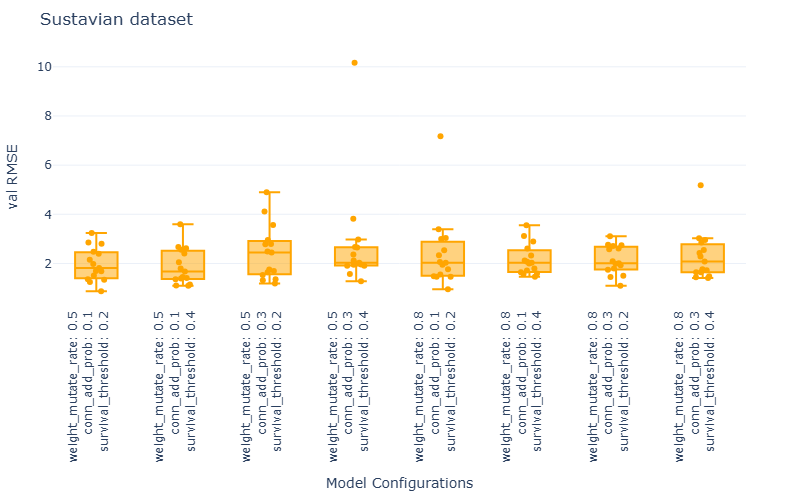

In [31]:
rmse_by_config = defaultdict(list)

# Loop through each outer fold
for outer in all_results:
    # outer['inner_results'] is a list of lists of result dicts
    for inner_fold_results in outer['inner_results']:
        for result in inner_fold_results:
            if not isinstance(result, dict):
                continue  

            # Generate a readable key from dynamic parameters
            key = ''
            for k, v in result.get('dynamic_params', {}).items():
                key += f"{k}: {v} <br /> "
            
            # Append the final RMSE on val set
            rmse_by_config[key].append(result['rmse_val_final'])

# Build the boxplot
fig = go.Figure()
for config, rmse_values in rmse_by_config.items():
    fig.add_trace(go.Box(
        y=rmse_values,
        boxpoints='all',
        jitter=0.5,
        pointpos=0,
        line=dict(color='orange'),
        name=config
    ))

fig.update_layout(
    title=DATASET_NAME + ' dataset',
    xaxis_title='Model Configurations',
    yaxis_title='val RMSE',
    height=500,
    width=1100,
    xaxis_tickangle=-90,
    yaxis_range=[0, None],
    margin=dict(l=50, r=50, t=50, b=20),
    showlegend=False,
    template='plotly_white'
)

fig.show()

This box plot shows validation RMSE across different model configurations, varying `weight_mutate_rate`, `conn_add_prob`, and `survival_threshold`. Most RMSE values fall between 1.0 and 3.5, with some outliers up to around 10.0. A `weight_mutate_rate` of 0.5 tends to produce more stable and lower RMSE results compared to 0.8, suggesting that moderate weight mutation avoids overly disruptive changes during training. Lower `conn_add_prob` (for example 0.1) is associated with tighter RMSE distributions and fewer outliers, likely due to more controlled structural evolution in the model. Similarly, a `survival_threshold` of 0.2 or 0.4 helps maintain consistent performance, possibly by filtering out weaker individuals more effectively. In contrast, higher `conn_add_prob` or `weight_mutate_rate: 0.8` introduces greater variability and more extreme outliers, indicating unstable training outcomes. Overall, moderate mutation and conservative connection growth result in better and more reliable performance.


<a id="subchapter_7_3_2"></a>
#### Train vs val Fitness 

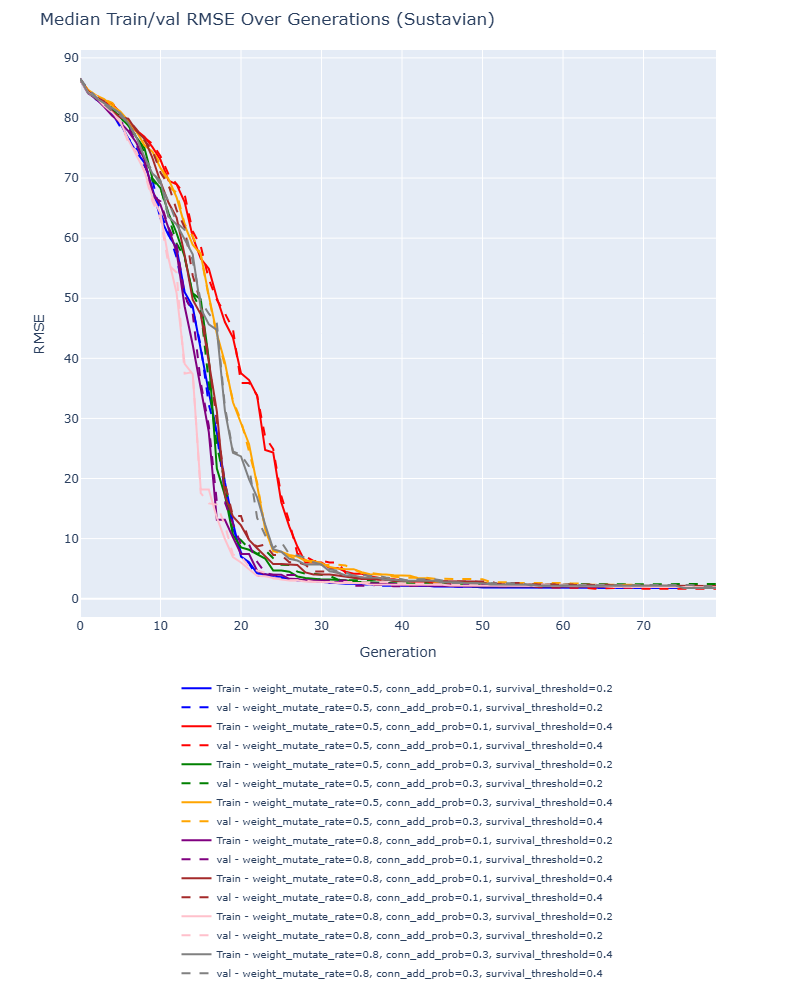

In [33]:
# Group by parameter combo and generation, then calculate median RMSE
median_rmse = df_all.groupby(['params', 'generation'])[['rmse_train', 'rmse_val']].median().reset_index()

# Step 1: More distinct colors
color_palette = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

fig = go.Figure()

# Step 2: Group and plot
for i, (param_key, group) in enumerate(median_rmse.groupby('params')):
    color = color_palette[i % len(color_palette)]
    
    # Train RMSE
    fig.add_trace(go.Scatter(
        x=group['generation'],
        y=group['rmse_train'],
        mode='lines',
        name=f'Train - {param_key}',
        line=dict(color=color, dash='solid')
    ))
    
    # val RMSE
    fig.add_trace(go.Scatter(
        x=group['generation'],
        y=group['rmse_val'],
        mode='lines',
        name=f'val - {param_key}',
        line=dict(color=color, dash='dash')
    ))

# Step 3: Layout customization
fig.update_layout(
    title=f'Median Train/val RMSE Over Generations ({DATASET_NAME})',
    xaxis_title='Generation',
    yaxis_title='RMSE',
    height=1000,  
    width=1200,
    margin=dict(t=50, b=100),  
    legend=dict(
        orientation='h',       
        x=0.5,                 
        y=-0.10,              
        xanchor='center',
        yanchor='top',
        font=dict(size=10),
        traceorder="normal",   
        title=None             
    )
)


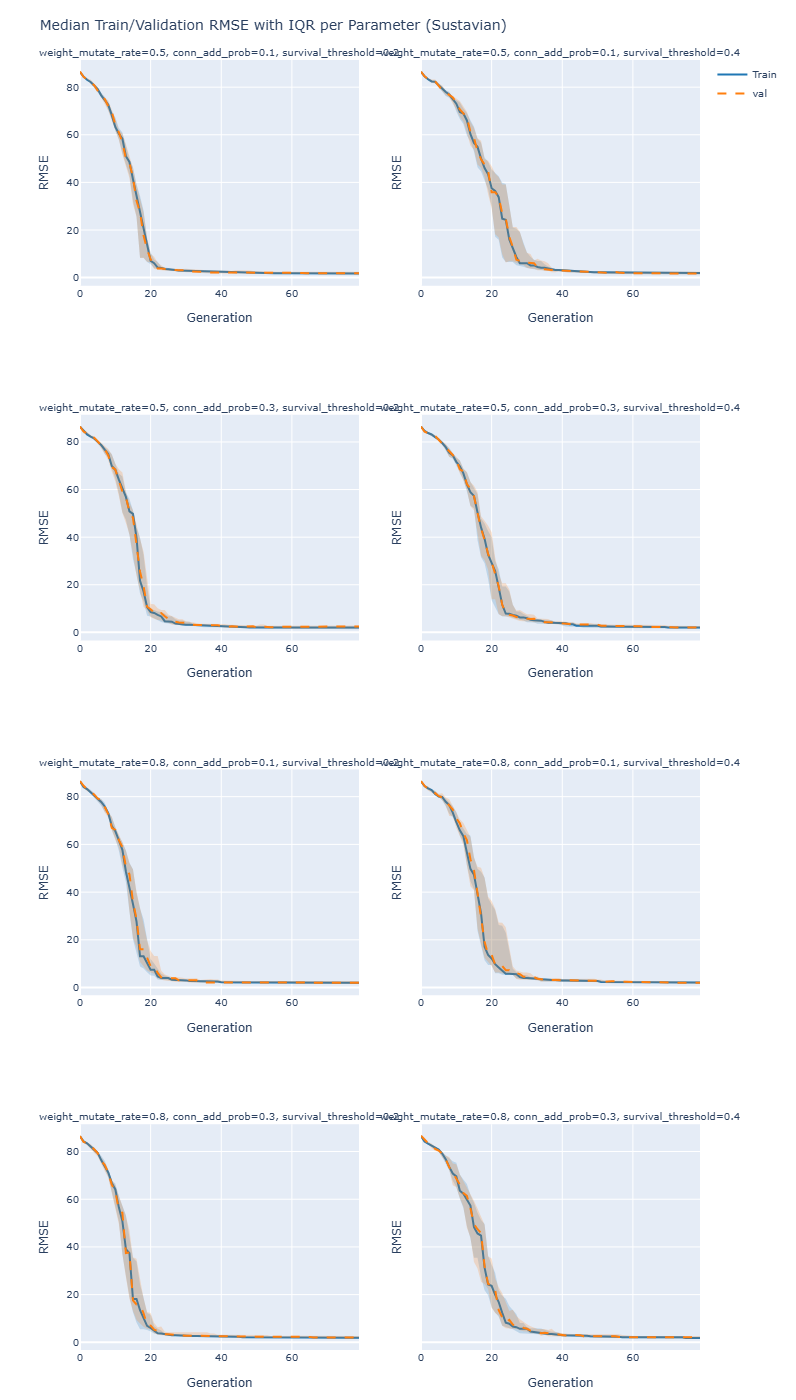

In [34]:
### Subplots with representation of variation ###

# Aggregate data
agg = df_all.groupby(['params', 'generation']).agg(
    rmse_train_median=('rmse_train', 'median'),
    rmse_val_median=('rmse_val', 'median'),
    rmse_train_q25=('rmse_train', lambda x: x.quantile(0.25)),
    rmse_train_q75=('rmse_train', lambda x: x.quantile(0.75)),
    rmse_val_q25=('rmse_val', lambda x: x.quantile(0.25)),
    rmse_val_q75=('rmse_val', lambda x: x.quantile(0.75)),
).reset_index()

param_sets = agg['params'].unique()
n_params = len(param_sets)

# Subplot layout
n_cols = 2
n_rows = (n_params + n_cols - 1) // n_cols

fig = make_subplots(
    rows=n_rows, cols=n_cols,
    subplot_titles=param_sets,
    shared_yaxes=True,
    vertical_spacing=0.1,
)

# One color for Train and one for val
train_color = 'rgba(31,119,180,1)'  # blue
val_color = 'rgba(255,127,14,1)'   # orange
train_fill = train_color.replace(',1)', ',0.2)')
val_fill = val_color.replace(',1)', ',0.2)')

for i, param_key in enumerate(param_sets):
    row = i // n_cols + 1
    col = i % n_cols + 1

    group = agg[agg['params'] == param_key]

    # Shaded Train RMSE IQR
    fig.add_trace(go.Scatter(
        x=group['generation'].tolist() + group['generation'].tolist()[::-1],
        y=group['rmse_train_q75'].tolist() + group['rmse_train_q25'].tolist()[::-1],
        fill='toself',
        fillcolor=train_fill,
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo='skip',
        showlegend=False,
        name='Train IQR'
    ), row=row, col=col)

    # Median Train RMSE line
    fig.add_trace(go.Scatter(
        x=group['generation'],
        y=group['rmse_train_median'],
        mode='lines',
        name='Train' if i == 0 else None,
        line=dict(color=train_color, dash='solid'),
        showlegend=(i == 0)
    ), row=row, col=col)

    # Shaded val RMSE IQR
    fig.add_trace(go.Scatter(
        x=group['generation'].tolist() + group['generation'].tolist()[::-1],
        y=group['rmse_val_q75'].tolist() + group['rmse_val_q25'].tolist()[::-1],
        fill='toself',
        fillcolor=val_fill,
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo='skip',
        showlegend=False,
        name='val IQR'
    ), row=row, col=col)

    # Median val RMSE line
    fig.add_trace(go.Scatter(
        x=group['generation'],
        y=group['rmse_val_median'],
        mode='lines',
        name='val' if i == 0 else None,
        line=dict(color=val_color, dash='dash'),
        showlegend=(i == 0)
    ), row=row, col=col)

# Layout
fig.update_layout(
    height=350 * n_rows,
    width=1000,
    title_text=f'Median Train/Validation RMSE with IQR per Parameter ({DATASET_NAME})',
    margin=dict(t=60, b=50),
)

fig.update_xaxes(title_text='Generation')
fig.update_yaxes(title_text='RMSE')
fig.update_layout(
    font=dict(size=10)  # Adjust to your preference (e.g., 8–12)
)

for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i].font.size = 10  # Smaller subplot title font


fig.show()


These graphs show how different NEAT configurations influence model performance over generations, using median Train and Validation RMSE with IQR bands to capture both accuracy and consistency. Across all setups, we see rapid error reduction in the first 20–30 generations, indicating early convergence, however not so much as early as GSGP and GP. Afterward, RMSE stabilizes near 2, showing the model quickly reaches near-optimal performance.

Configurations with `weight_mutate_rate=0.5` consistently perform well and show narrow IQR bands, meaning they converge not only quickly but also consistently across runs. This moderate mutation rate seems to provide enough variation for learning without causing instability. On the other hand, `weight_mutate_rate=0.8` tends to introduce more randomness, especially when paired with `survival_threshold=0.4`, which leads to wider IQRs and less predictable training.

Lower `conn_add_prob` values like 0.1 contribute to tighter performance ranges, likely because they slow down structural changes in the networks, making the evolutionary process more controlled. Meanwhile, lower `survival_threshold` values like 0.2 help prune weaker individuals early, supporting fast and stable convergence.

In summary, while most configurations eventually reach low RMSE, the combination of `weight_mutate_rate=0.5`, `conn_add_prob=0.1`, and `survival_threshold=0.2` consistently delivers both early convergence and stable results. Other combinations work, but with greater variation and risk of unstable training dynamics.

Overall, Train and Validation RMSE lines stay close together with overlapping shaded bands, showing minimal overfitting, suggesting that the model learns general patterns instead of memorizing data.

<a id="subchapter_7_3_4"></a>
#### Fitness Diversity

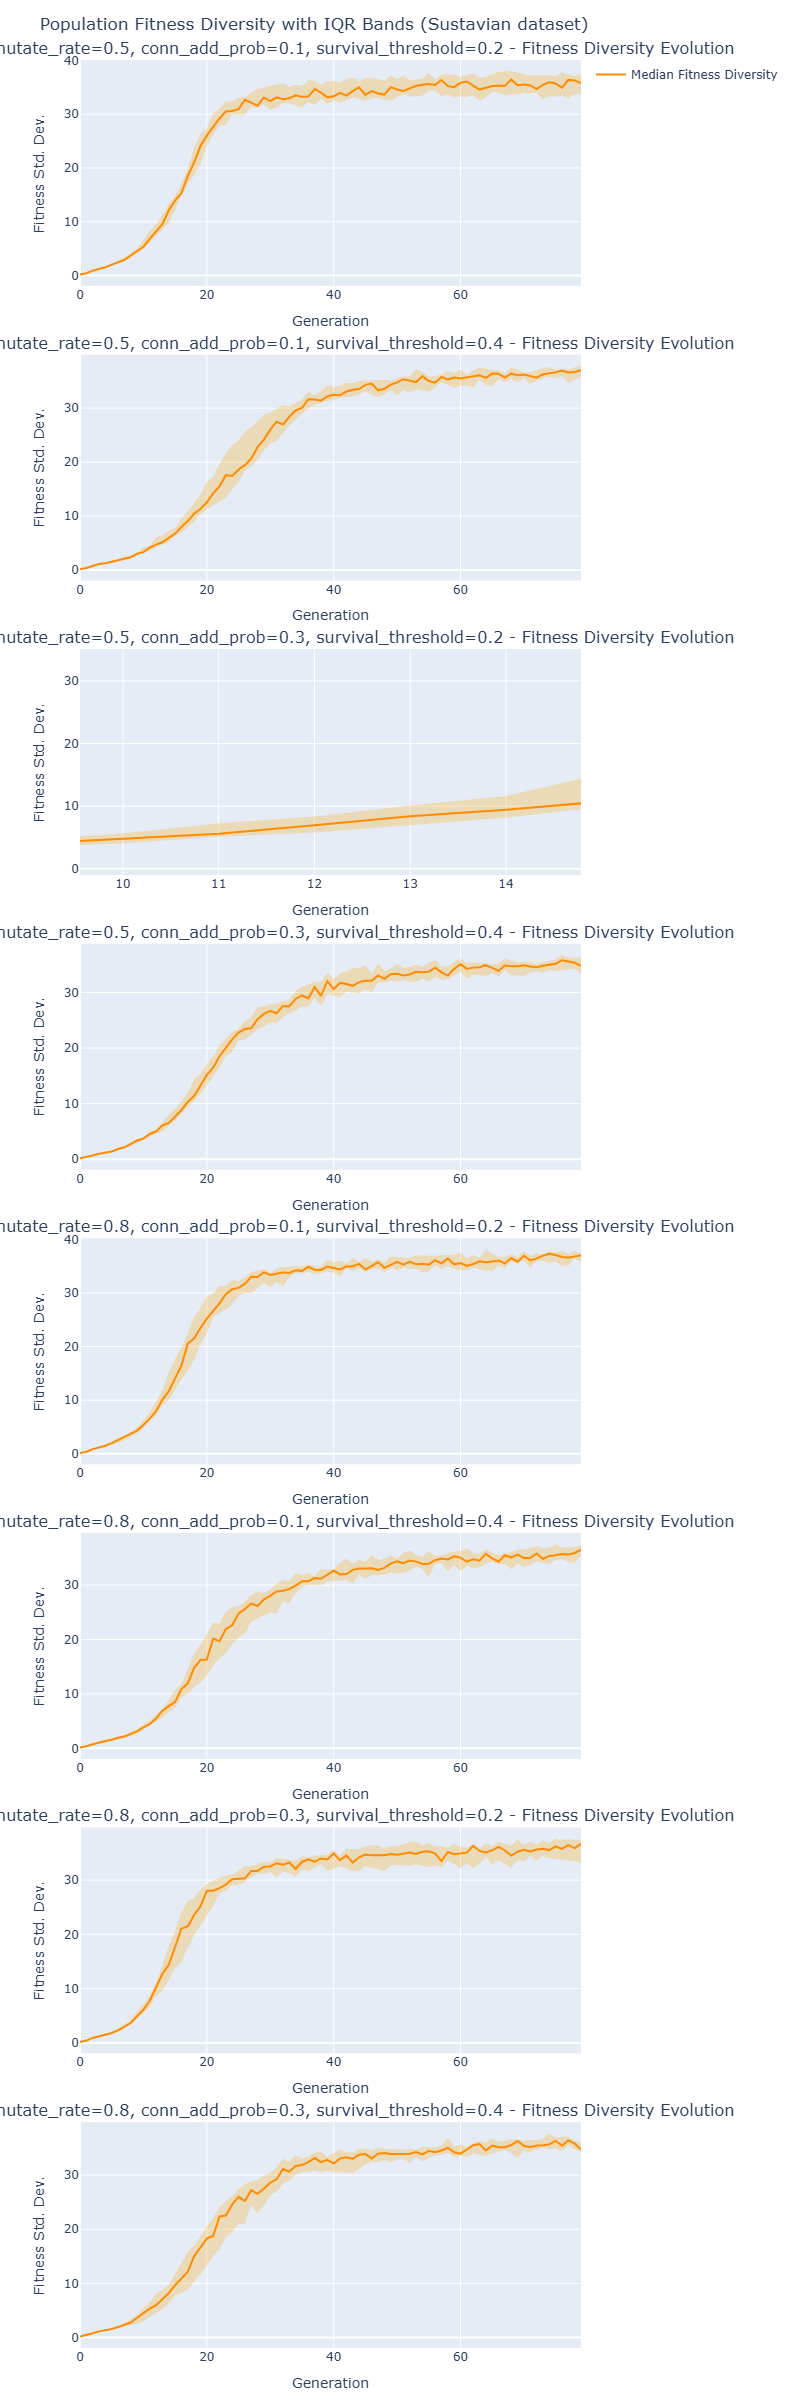

In [35]:
# Compute median + IQR for fitness diversity per generation and param
fitness_diversity = df_all.groupby(['params', 'generation']).agg(
    fitness_median=('rmse_train_std', 'median'),
    fitness_q25=('rmse_train_std', lambda x: x.quantile(0.25)),
    fitness_q75=('rmse_train_std', lambda x: x.quantile(0.75)),
).reset_index()

# Unique parameter sets
unique_params = fitness_diversity['params'].unique()
n_params = len(unique_params)

# Create subplots: 1 row per param
fig = make_subplots(
    rows=n_params, cols=1,
    subplot_titles=[f'{param} - Fitness Diversity Evolution' for param in unique_params],
    vertical_spacing=0.03
)

# Styling
line_color = 'darkorange'
fill_color = 'rgba(255,165,0,0.25)'  # semi-transparent orange

for i, param in enumerate(unique_params):
    group = fitness_diversity[fitness_diversity['params'] == param]
    row = i + 1

    # Add IQR fill (shaded area)
    fig.add_trace(go.Scatter(
        x=group['generation'].tolist() + group['generation'].tolist()[::-1],
        y=group['fitness_q75'].tolist() + group['fitness_q25'].tolist()[::-1],
        fill='toself',
        fillcolor=fill_color,
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo='skip',
        showlegend=False,
        name='Fitness IQR'
    ), row=row, col=1)

    # Add median line
    fig.add_trace(go.Scatter(
        x=group['generation'],
        y=group['fitness_median'],
        mode='lines',
        line=dict(color=line_color),
        name='Median Fitness Diversity' if i == 0 else None,
        showlegend=(i == 0)
    ), row=row, col=1)

# Layout
fig.update_layout(
    height=300 * n_params,
    width=900,
    title_text=f'Population Fitness Diversity with IQR Bands ({DATASET_NAME} dataset)',
    margin=dict(t=60, b=40),
)

# Axes labels
for row in range(1, n_params + 1):
    fig.update_xaxes(title_text='Generation', row=row, col=1)
    fig.update_yaxes(title_text='Fitness Std. Dev.', row=row, col=1)

fig.show()




Overall, fitness diversity increases rapidly during the first **20–30 generations**, while RMSE decreases sharply. This inverse relationship suggests that as the population explores a wide range of individuals early on, it quickly discovers better-performing solutions. The rising diversity helps avoid local optima by encouraging exploration, while still improving performance.

After this phase, diversity stabilizes around **33–37**, and RMSE levels off near its lowest point. This indicates the population retains enough variation to keep exploring without losing convergence stability.

Configurations with `weight_mutate_rate=0.5` show consistent and steady diversity growth, which aligns with smooth RMSE reduction. Both `survival_threshold=0.2` and `0.4` lead to similar final diversity levels, though `0.2` tends to support more stable early development.

Higher `weight_mutate_rate=0.8` increases diversity but also adds more variability across runs, especially with `survival_threshold=0.4`, making convergence less predictable.

In short, early diversity growth supports convergence by allowing the population to explore broadly, while later stability in both diversity and RMSE shows the algorithm has found and preserved strong individuals.

<a id="chapter_8"></a>
### Final Evaluation

In [36]:

def select_best_params(inner_results):
    """
    Returns the dynamic_params dict from the config with the lowest average rmse_val_final across inner folds.
    """
    best_params = None
    best_score = float('inf')

    # Group results by config across inner folds:
    # zip(*inner_results) will pair results for the same config across all inner folds
    for config_results in zip(*inner_results):
        try:
            # Collect the rmse_val_final for this config from each inner fold
            rmse_vals = [res['rmse_val_final'] for res in config_results]
            mean_rmse = np.mean(rmse_vals)
            if mean_rmse < best_score:
                best_score = mean_rmse
                best_params = config_results[0]['dynamic_params']
        except KeyError as e:
            print(f"Missing key {e} in one of the results, skipping this config")
            continue

    return best_params



In [38]:
best_rmse = float('inf')
best_genome = None
outer_fold_metrics = []  

for i_outer, result in enumerate(all_results):
    print(f"\n=== Final Evaluation for Outer Fold {i_outer} ===")

    test_ix = result['test_ix']
    learning_ix = np.setdiff1d(np.arange(len(X)), test_ix)

    X_learning, y_learning = X[learning_ix], y[learning_ix]
    X_test, y_test = X[test_ix], y[test_ix]

    final_scaler = RobustScaler()
    X_train_final_scaled = final_scaler.fit_transform(X_learning)
    X_test_final_scaled = final_scaler.transform(X_test)

    best_params = select_best_params(result['inner_results'])

    fixed_params.update({
        "X_train": X_train_final_scaled,
        "y_train": y_learning.numpy(),
        "X_val": X_test_final_scaled,
        "y_val": y_test.numpy(),
        "config_template": "temp_neat_config.cfg"
    })

    final_result, _ = call_neat(
        fixed_params,
        param_grid={k: [v] for k, v in best_params.items()},
        seed=seed + i_outer * 1000
    )

    result['final_eval'] = final_result

    for model_info in final_result:
        train_rmse = model_info['rmse_train_history'][-1]
        test_rmse = model_info['rmse_val_history'][-1] # Note: 'rmse_val_history' here refears to the test data because of how NEAT and the splits are set up.
        outer_fold_metrics.append({
            'outer_fold': i_outer,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'params': best_params,
            'rmse_test_history' : model_info['rmse_val_history'], 
            'rmse_train_history' : model_info['rmse_train_history']
        })


=== Final Evaluation for Outer Fold 0 ===

=== Final Evaluation for Outer Fold 1 ===

=== Final Evaluation for Outer Fold 2 ===

=== Final Evaluation for Outer Fold 3 ===

=== Final Evaluation for Outer Fold 4 ===


In [39]:
df_metrics = pd.DataFrame(outer_fold_metrics)
df_metrics.to_csv("outer_fold_metrics_neat.csv", index=False)

In [43]:
# Load summary CSV if you saved it
df_summary = pd.read_csv("outer_fold_metrics_neat.csv")

# Prepare the DataFrame for box plot (long format)
df_plot = pd.melt(
    df_summary,
    id_vars=['outer_fold', 'params'],
    value_vars=['train_rmse', 'test_rmse'],
    var_name='Metric',
    value_name='RMSE'
)


In [1]:
df_plot

NameError: name 'df_plot' is not defined

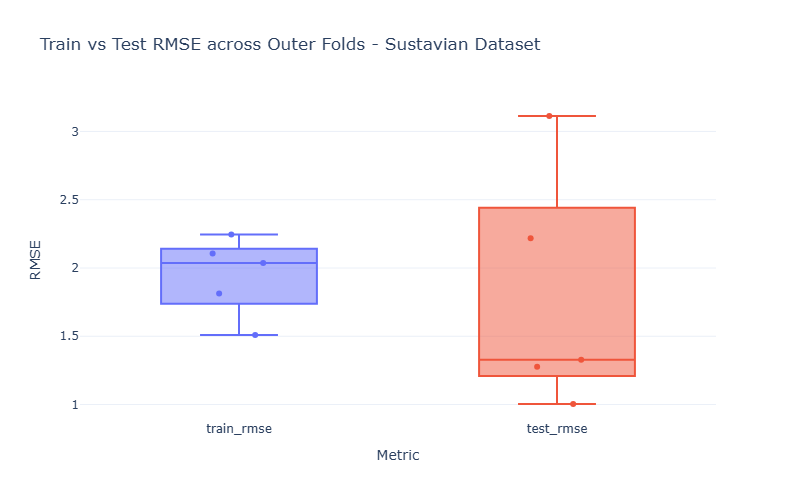

In [46]:
fig = px.box(
    df_plot,
    x='Metric',
    y='RMSE',
    color='Metric',
    points='all',          
    title=f"Train vs Test RMSE across Outer Folds - {DATASET_NAME} Dataset",
    template='plotly_white'
)

fig.update_traces(
    jitter=0.4,             
    pointpos=0              
)

fig.update_layout(
    height=500,
    width=700,
    xaxis_title='Metric',
    yaxis_title='RMSE',
    showlegend=False
)

fig.show()




Train RMSE has a median around 2.0 with a narrow spread, showing consistent and stable learning on the training data across folds.

Test RMSE has a surprisingly lower median (~1.32) but much wider variability, ranging from about 1.0 to 3.1. This suggests the model often generalizes very well, sometimes even better than on training data, though its performance varies significantly between folds.

Since the median test RMSE is lower than the train RMSE, there’s no sign of overfitting. Instead, the main concern is the inconsistency in generalization, highlighted by the broad test RMSE range.

Overall, the model shows strong predictive power on average, but some folds yield much worse performance. More folds would provide a more accurate and reliable assessment of the model’s consistency.

#### Summary: 
**Overfitting** <br>
The model shows no significant overfitting, as train and test RMSE medians are close. Slightly higher variability in test RMSE reflects natural differences across data splits rather than memorization.<br>

**Early Convergence** <br>
Fitness diversity rises rapidly in early generations, promoting exploration. This diversity peak aligns roughly with the period when RMSE drops and the model approaches optimal performance. After this, diversity stabilizes and the algorithm converges, balancing exploration and exploitation effectively.
